In [ ]:
%pip install tensorflow

import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement  ...........PIL (Python Imaging Library)
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # to create the nural networks layes 
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers 
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/376.0 MB 1.9 MB/s eta 0:03:22
   ---------------------------------------- 1.0/376.0 MB 2.0 MB/s eta 0:03:07
   ---------------------------------------- 1.6/376.0 MB 2.0 MB

Load Datasets

In [6]:
# Directories for training and testing data
train_dir = r'C:\Users\AKSHAD\Downloads\archive (3)\Training'
test_dir = r'C:\Users\AKSHAD\Downloads\archive (3)\Testing'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

Data Visualization

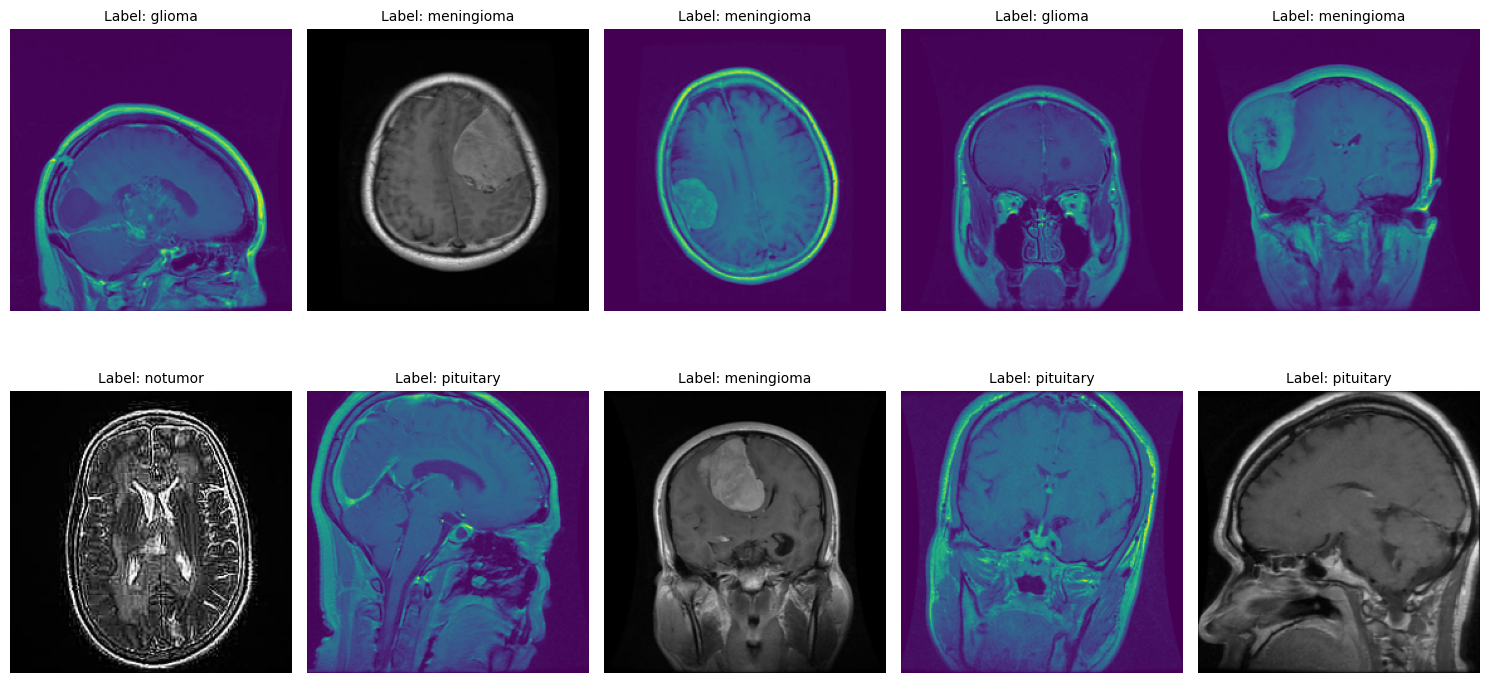

In [7]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

Image Prprocessing(helper functions)

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))  # Convert numpy array to PIL Image
    # Randomly apply brightness, contrast, and sharpness adjustments
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image)
    return image  # Convert back to numpy array

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))  # Load and resize image
        image = np.array(image)  # Convert PIL Image to numpy array
        image = augment_image(image)
        images.append(image)
    return np.array(images)
# convert label names into integers
def encode_labels(labels):
    unique_labels = os.listdir(train_dir)
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data genrator function to yield batches of images and labels
def dataget(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i + batch_size]
            yield batch_images, batch_labels

MODEL:
WE ARE USING VGG16 FOR TRANSFER LEARNING.
The model is built on top of VGG16, which is a pre-trained convolutional neural network (CNN) for image classification.

First, the VGG16 model is loaded with input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet'. The input shape is set to match the size of the images in the dataset, which is 128x128 pixels. The include_top parameter is set to False, which means that the final fully-connected layers of VGG16 that perform the classification will not be included. The weights parameter is set to 'imagenet' which means that the model will be pre-trained with a dataset of 1.4 million images called imagenet

Next, the for layer in base_model.layers: loop is used to set all layers of the base_model (VGG16) to non-trainable, so that the weights of these layers will not be updated during training.

Then, the last three layers of the VGG16 model are set to trainable by using base_model.layers[-2].trainable = True,base_model.layers[-3].trainable = True and base_model.layers[-4].trainable = True

After that, a Sequential model is created and the VGG16 model is added to it with model.add(base_model).

Next, a Flatten layer is added to the model with model.add(Flatten()) which reshapes the output of the VGG16 model from a 3D tensor to a 1D tensor, so that it can be processed by the next layers of the model.

Then, a Dropout layer is added with model.add(Dropout(0.3)) which is used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

After that, a dense layer is added with 128 neurons and relu activation function is added with model.add(Dense(128, activation='relu')).

Next, another Dropout layer is added with model.add(Dropout(0.2))

Finally, the output dense layer is added with number of neurons equal to the number of unique labels and 'softmax' activation function is added with model.add(Dense(len(unique_labels), activation='softmax')). The 'softmax' activation function is used to give a probability distribution over the possible classes.

In [ ]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization # drop 30 percent neurons
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Encode train labels to integers
encoded_train_labels = encode_labels(train_labels)

# Train the model
history = model.fit(dataget(train_paths, encoded_train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 207s 717ms/step - loss: 1.4191 - sparse_categorical_accuracy: 0.6791
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 197s 693ms/step - loss: 0.4003 - sparse_categorical_accuracy: 0.8536
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 198s 695ms/step - loss: 0.3037 - sparse_categorical_accuracy: 0.8877
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 197s 690ms/step - loss: 0.2193 - sparse_categorical_accuracy: 0.9223
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 193s 679ms/step - loss: 0.1631 - sparse_categorical_accuracy: 0.9435


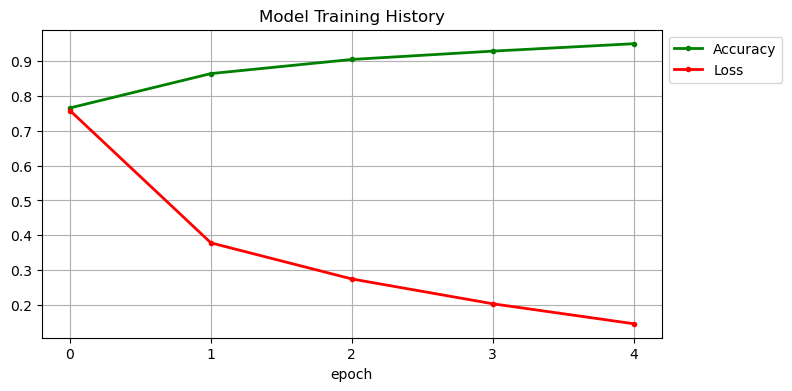

In [25]:
plt.figure(figsize = (8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

Model Classifiaction Report

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

#prediction on test data
test_images = open_images(test_paths)
test_labels_encoded = encode_labels(test_labels)  

#predict using the trained model
test_predictions = model.predict(test_images)

# classification report
print('Classification Report:')
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))



41/41 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       300
           1       0.83      0.92      0.87       306
           2       0.98      0.99      0.99       405
           3       0.99      0.84      0.91       300

    accuracy                           0.93      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.93      0.93      1311



Model confusion plot

Confusion Matrix:
[[286  14   0   0]
 [ 15 283   6   2]
 [  0   3 402   0]
 [  3  42   2 253]]


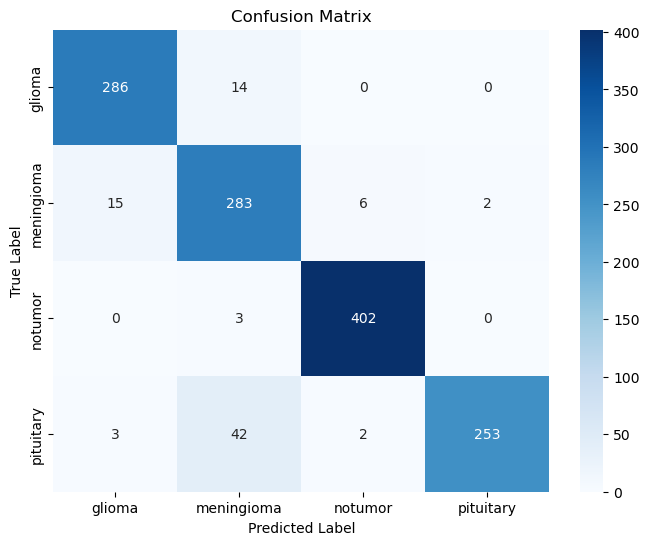

In [28]:
# confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print('Confusion Matrix:')
print(conf_matrix)  

#plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



A ROC (Receiver Operating Characteristic) curve is a graphical representation used to assess the performance of a binary classifier, plotting the True Positive Rate (also known as sensitivity or recall) against the False Positive Rate (1 minus specificity) at various threshold settings. Essentially, it shows how well a model distinguishes between two classes (e.g., positive and negative) across different decision criteria. 


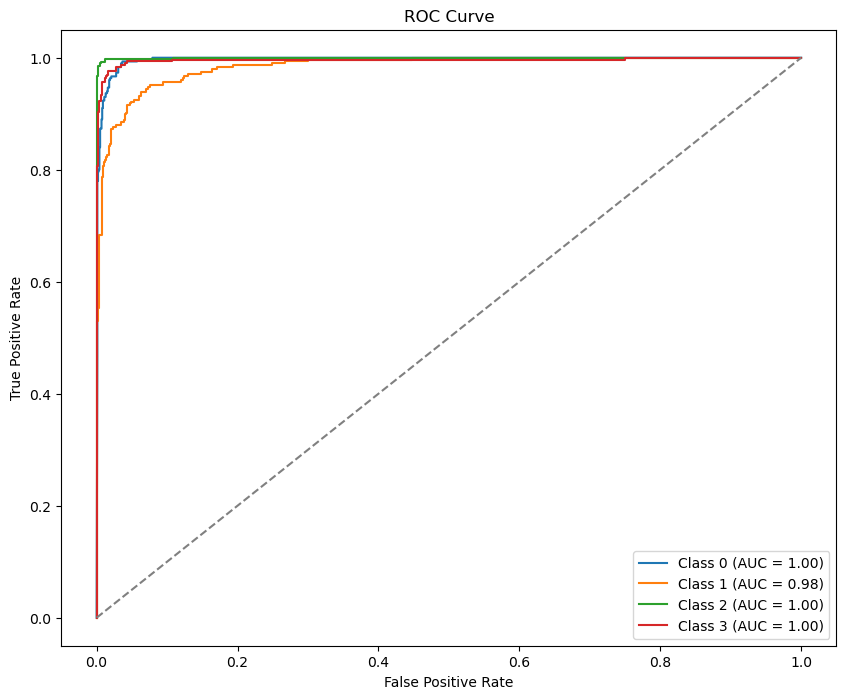

In [29]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

Save and load model

In [ ]:
model.save('model.hs')

In [33]:
from tensorflow.keras.models import load_model
# Load the model
model = load_model('model.h5')

In [34]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

class_labels = ['pituitary','glioma','notumor','meningioma']
  # Get class labels from training directory
def detect_and_display(img_path,model,image_size = 128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


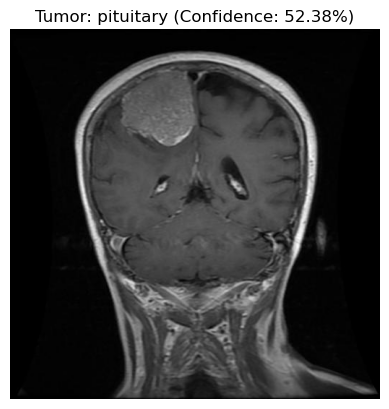

In [36]:
image_path = r"C:\Users\AKSHAD\Downloads\archive (3)\Testing\meningioma\Te-me_0215.jpg"  # Replace with your image path
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


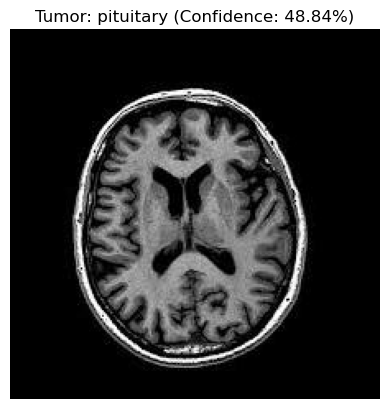

In [37]:
image_path = r"C:\Users\AKSHAD\Downloads\archive (3)\Testing\notumor\Te-no_0387.jpg"  # Replace with your image path
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


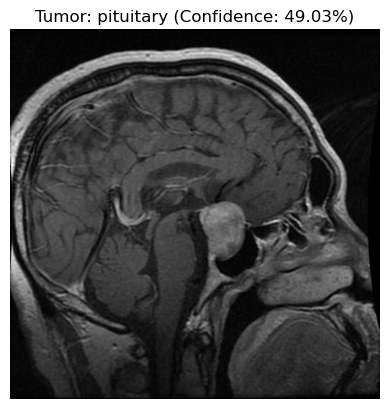

In [38]:
image_path = r"C:\Users\AKSHAD\Downloads\archive (3)\Testing\pituitary\Te-pi_0297.jpg"  # Replace with your image path
detect_and_display(image_path, model)

In [ ]:
"""
import streamlit as st
import numpy as np
from PIL import Image
from keras.models import load_model
import tensorflow as tf
import io

# Load your trained model
@st.cache_resource
def load_brain_tumor_model():
    model = load_model("model.h5")  # update path if different
    return model

model = load_brain_tumor_model()

# Enhanced preprocessing function to handle shape mismatches
def preprocess_image(image: Image.Image):
    """
    Preprocess image to match model's expected input shape (128, 128, 3)
    """
    # Convert to RGB if not already (handles RGBA, grayscale, etc.)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Resize to match model input shape (128, 128)
    image = image.resize((128, 128))
    
    # Convert to numpy array
    img_array = np.array(image)
    
    # Ensure the image has 3 channels (RGB)
    if len(img_array.shape) == 2:  # Grayscale
        img_array = np.stack([img_array] * 3, axis=-1)
    elif img_array.shape[-1] == 4:  # RGBA
        img_array = img_array[:, :, :3]  # Remove alpha channel
    elif img_array.shape[-1] == 1:  # Single channel grayscale
        img_array = np.repeat(img_array, 3, axis=-1)  # Convert to RGB
    
    # Normalize pixel values to [0, 1]
    img_array = img_array.astype('float32') / 255.0
    
    # Add batch dimension: (1, 128, 128, 3)
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

# Define Streamlit UI
st.set_page_config(page_title="Brain Tumor Classifier", layout="centered")
st.title("🧠 Brain Tumor MRI Classification")
st.write("Upload an MRI scan image to detect if a tumor is present.")

# Add some helpful information
st.info("📋 Supported formats: JPG, PNG, JPEG. The image will be automatically resized to 128x128 pixels for analysis.")

# File uploader
uploaded_file = st.file_uploader("Choose an MRI image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    try:
        # Load and display the image
        image = Image.open(uploaded_file)
        
        # Display original image info
        st.write(f"**Original image size:** {image.size}")
        st.write(f"**Image mode:** {image.mode}")
        
        # Display the image
        st.image(image, caption="Uploaded MRI Image", use_column_width=True)
        
        # Predict button
        if st.button("🔍 Analyze MRI Scan"):
            with st.spinner("⏳ Analyzing the MRI scan..."):
                try:
                    # Preprocess the image
                    processed_image = preprocess_image(image)
                    
                    # Display processed image shape for debugging
                    st.write(f"**Processed image shape:** {processed_image.shape}")
                    
                    # Make prediction
                    prediction = model.predict(processed_image)
                    predicted_class = np.argmax(prediction, axis=1)[0]
                    confidence = np.max(prediction) * 100
                    
                    # Class mapping (adjust based on your model's classes)
                    class_names = ['No Tumor', 'Meningioma', 'Glioma', 'Pituitary']
                    result = class_names[predicted_class]
                    
                    # Display results
                    st.success(f"🧠 **Prediction: {result}**")
                    st.write(f"**Confidence: {confidence:.2f}%**")
                    
                    # Show probability distribution
                    st.subheader("📊 Prediction Probabilities")
                    prob_dict = {class_names[i]: prediction[0][i] for i in range(len(class_names))}
                    st.bar_chart(prob_dict)
                    
                    # Add disclaimer
                    st.warning("⚠️ **Disclaimer:** This is an AI prediction tool for educational purposes only. Always consult with qualified medical professionals for proper diagnosis and treatment.")
                    
                except Exception as e:
                    st.error(f"❌ Error during prediction: {str(e)}")
                    st.write("Please check that your model file is compatible and accessible.")
                    
    except Exception as e:
        st.error(f"❌ Error loading image: {str(e)}")
        st.write("Please make sure you've uploaded a valid image file.")

# Add sidebar with additional information
with st.sidebar:
    st.header("ℹ️ About")
    st.write("""
    This application uses a deep learning model to classify brain MRI scans into four categories:
    - **No Tumor**: Healthy brain tissue
    - **Meningioma**: Tumor of the meninges
    - **Glioma**: Tumor of glial cells
    - **Pituitary**: Pituitary gland tumor
    """)
    
    st.header("🔧 Technical Details")
    st.write("- **Input Size:** 128 × 128 pixels")
    st.write("- **Model:** VGG16-based CNN")
    st.write("- **Format:** RGB images")
    
    st.header("📝 Usage Tips")
    st.write("""
    - Upload clear MRI scan images
    - Supported formats: JPG, PNG, JPEG
    - Images are automatically preprocessed
    - Check confidence scores for reliability
    """)

# Load and preprocess image
img = Image.open(uploaded_file).convert("RGB")  # ensures 3 channels
img = img.resize((128, 128))                    # resize to expected shape
img_array = np.array(img) / 255.0               # normalize to [0, 1]
processed_image = np.expand_dims(img_array, axis=0)  # add batch dimension

# Predict
prediction = model.predict(processed_image)

"""